# **Import libraries**

In [24]:
# !pip install reparo

In [44]:
import pandas as pd
import numpy as np
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from reparo import KNNImputer
%matplotlib inline
import seaborn as sns

In [25]:
def draw_silhouette_plot(X, clusterer, n_clusters, ax):
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    ax.set_xlim([-1, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    ax.set_yticks([])
    ax.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    y_lower = 10
    for i in range(n_clusters):
        ith_values = sample_silhouette_values[cluster_labels == i]
        ith_values.sort()
        size_cluster_i = ith_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)

        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )
        y_lower = y_upper + 10

    ax.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax.set_title(f"Silhouette plot for n_clusters = {n_clusters}")

# **Import Dataset**

[Chosen Dataset](https://www.kaggle.com/datasets/kunalgupta2616/hackerearth-customer-segmentation-hackathon)

In [45]:
df_train = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "kunalgupta2616/hackerearth-customer-segmentation-hackathon",
  'avhacklive/Train.csv'
)
df_test = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "kunalgupta2616/hackerearth-customer-segmentation-hackathon",
  'avhacklive/Test.csv'
)
df = pd.concat([df_train, df_test], axis=0, ignore_index=True)

Using Colab cache for faster access to the 'hackerearth-customer-segmentation-hackathon' dataset.
Using Colab cache for faster access to the 'hackerearth-customer-segmentation-hackathon' dataset.


# **Analyse Dataset**

In [5]:
df.head()

,id,customer_age,job_type,marital,education,default,balance,housing_loan,personal_loan,communication_type,day_of_month,month,last_contact_duration,num_contacts_in_campaign,days_since_prev_campaign_contact,num_contacts_prev_campaign,prev_campaign_outcome,term_deposit_subscribed
0,id_43823,28.0,management,single,tertiary,no,285.0,yes,no,unknown,26,jun,303.0,4.0,NaN,0,unknown,0.0
1,id_32289,34.0,blue-collar,married,secondary,no,934.0,no,yes,cellular,18,nov,143.0,2.0,132.0,1,other,0.0
2,id_10523,46.0,technician,married,secondary,no,656.0,no,no,cellular,5,feb,101.0,4.0,NaN,0,unknown,0.0
3,id_43951,34.0,services,single,secondary,no,2.0,yes,no,unknown,20,may,127.0,3.0,NaN,0,unknown,0.0
4,id_40992,41.0,blue-collar,married,primary,no,1352.0,yes,no,cellular,13,may,49.0,2.0,NaN,0,unknown,0.0


We won't need id -> drop it.

In [46]:
df.drop('id', axis=1, inplace=True)

In [8]:
pd.DataFrame({
    'unique': df.nunique(),
    'nan': df.isna().sum(),
    'dtype': df.dtypes
})

,unique,nan,dtype
customer_age,79,889,float64
job_type,12,0,object
marital,3,231,object
education,4,0,object
default,2,0,object
balance,7622,580,float64
housing_loan,2,0,object
personal_loan,2,223,object
communication_type,3,0,object
day_of_month,31,0,int64


We will have troubles with missing values.

For days_since_prev_campaign I'll replace missing values with 0 and others to 1.

For months I'll map the values(they have some sort of relationship).

yes/no => 1/0

And I'll use dummies for some of the cols.

In [48]:
df['days_since_prev_campaign_contact'] = df['days_since_prev_campaign_contact'].isna().map({True: 0, False: 1})

In [49]:
months = {
    'jan': 0, 'feb': 1, 'mar': 2, 'apr': 3, 'may': 4, 'jun': 5,
    'jul': 6, 'aug': 7, 'sep': 8, 'oct': 9, 'nov': 10, 'dec': 11
}

df['month'] = df['month'].map(months)

In [50]:
outcomes = {'unknown': 0, 'failure': 0, 'other': 0.5, 'success': 1}

df['prev_campaign_outcome'] = df['prev_campaign_outcome'].map(outcomes)

In [51]:
yes_no = {'no': 0, 'yes': 1}

df['personal_loan'] = df['personal_loan'].map(yes_no)
df['housing_loan'] = df['housing_loan'].map(yes_no)
df['default'] = df['default'].map(yes_no)

In [52]:
education = {'tertiary': 3, 'secondary': 2, 'primary': 1, 'unknown': 0}

df['education'] = df['education'].map(education)

In [53]:
dum_cols = ['marital', 'communication_type', 'job_type']

df = pd.get_dummies(df, columns=dum_cols)

In [54]:
df[df.select_dtypes('bool').columns] = df.select_dtypes('bool').astype(int)

As I'll be using clustering methods, I'll replace missing values in all other features using KNNImputer

In [55]:
knnimputer = KNNImputer()

df = pd.DataFrame(
  knnimputer.fit_transform(df.values),
  columns=df.columns,
  index=df.index
)

In [56]:
std_scaler = StandardScaler()

df[['balance','customer_age']] = std_scaler.fit_transform(df[['balance','customer_age']])

# **GMM**

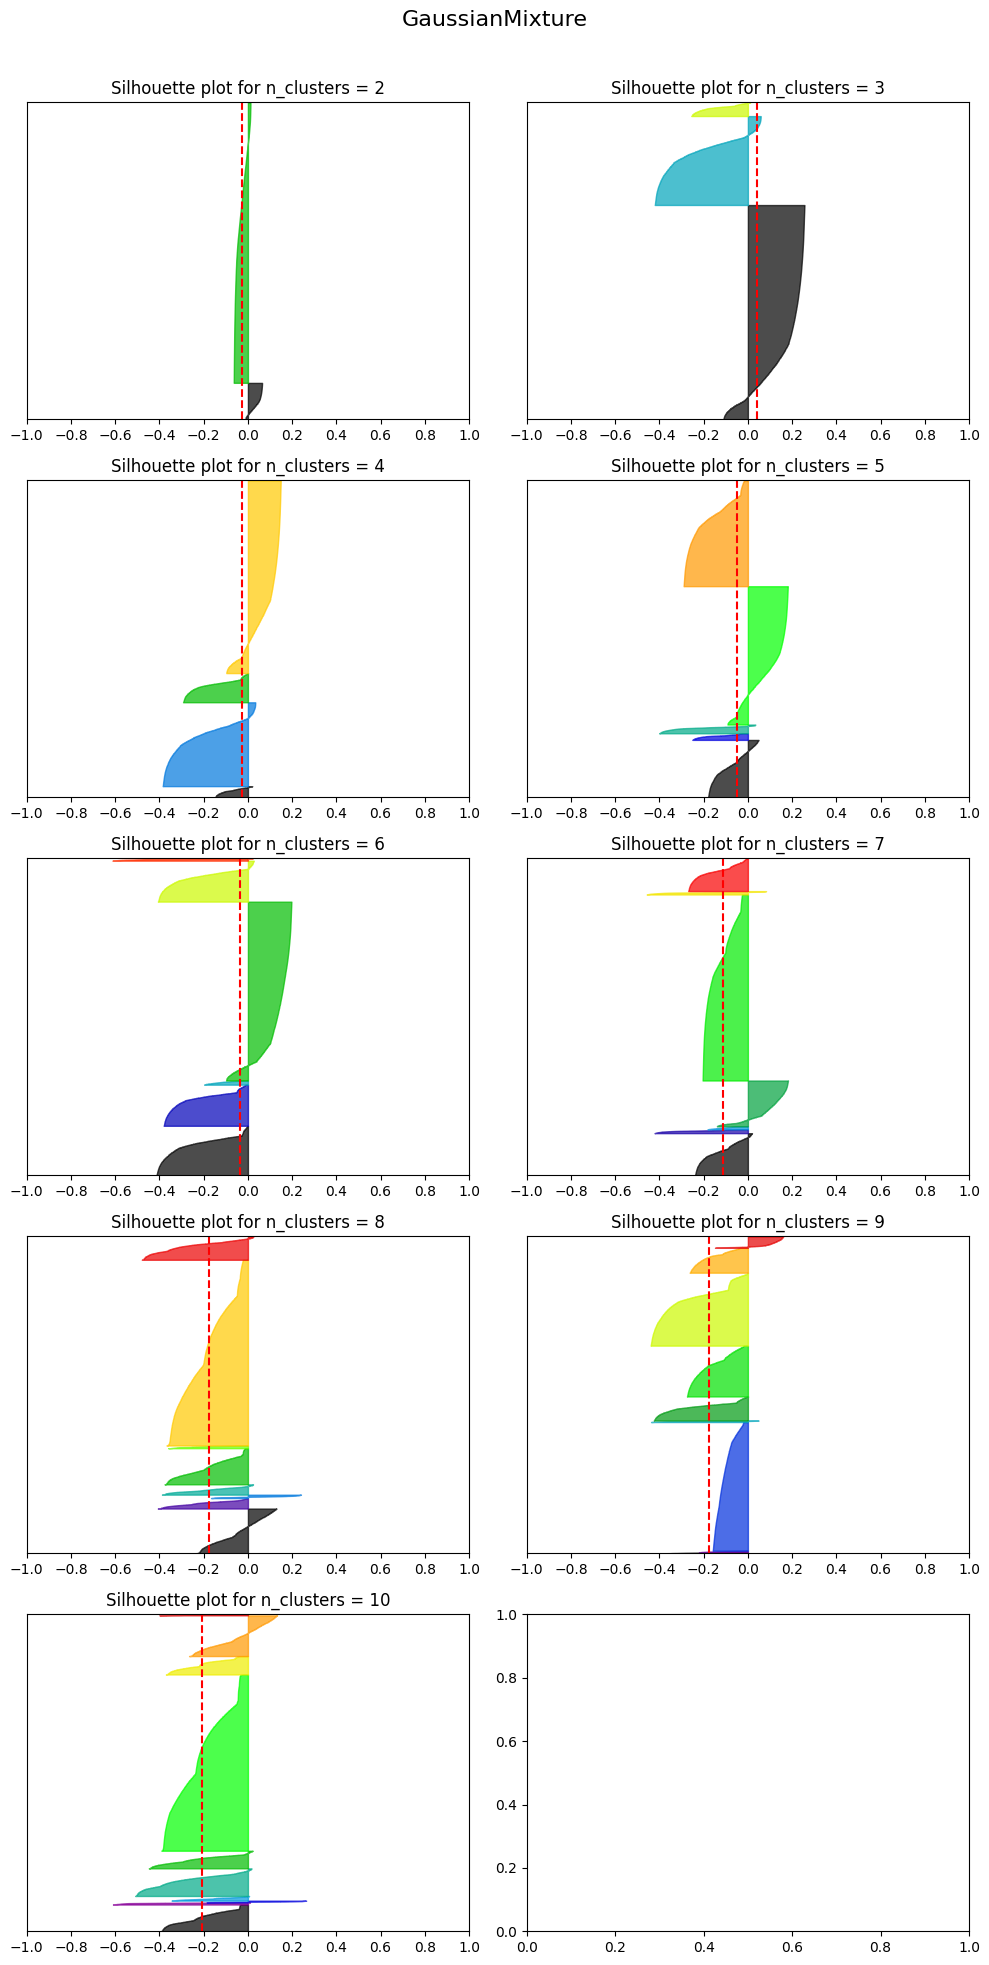

In [27]:
n_components = 10

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
fig.suptitle('GaussianMixture', fontsize=16)

idx = 0
for i in range(2, n_components + 1):
    draw_silhouette_plot(df, GaussianMixture(n_components=i, random_state=42), i, axs[idx // 2][idx % 2])
    idx += 1

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

By sihlouette score, everything is bad(really bad, negative).

2-3 clusters, even though have the best performance, they aren't informative.

So, I'll take 4 - the clusters ar pretty large(no 'noise') and the score is close to 0(bad, but we need to pick the lesser of two evils).

# **KMeans**

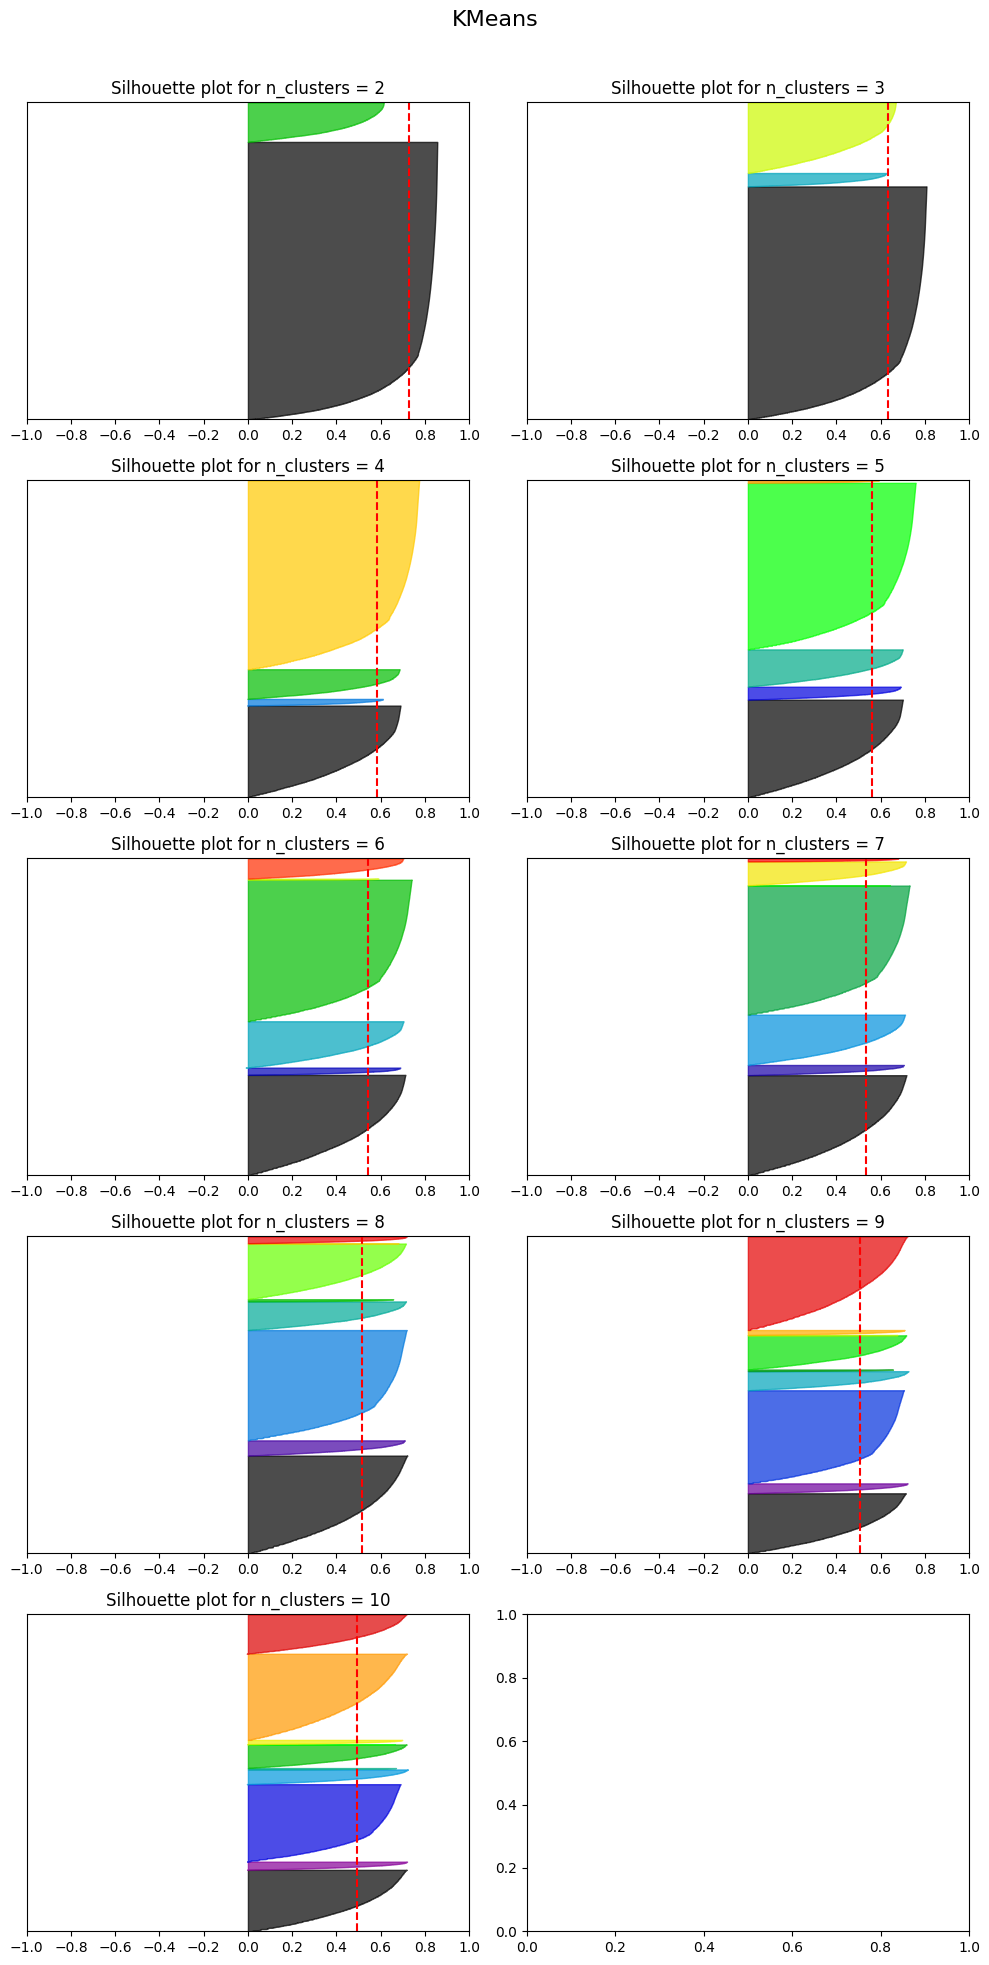

In [26]:
n_clusters = 10

fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
fig.suptitle('KMeans', fontsize=16)

idx = 0
for i in range(2, n_clusters + 1):
    draw_silhouette_plot(df, KMeans(n_clusters=i, random_state=42), i, axs[idx // 2][idx % 2])
    idx += 1

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

The top result is achieved by 2 clusters. However, as we want to make clusters, it won't be quite useful. 3 is also overperforming the rest, but after it the accuracy starts to decline slowly.

There is no big difference between 4-7 clusters, but I'll prefer a larger(but still reasonable) number. Instead of 7, I'll take 6, as the cluster formmed by 7 is so tiny that it would be difficult to analyze it.

# **Clustering**

*(I'll use the transpose of the table because I don't see all the features overwise)*

In [66]:
pd.options.display.float_format = '{:,.6f}'.format

## GMM

In [67]:
scaled_cols = ['balance', 'customer_age']

gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(df)

cluster_means = gmm.means_.copy()

scaled_idx = [df.columns.get_loc(c) for c in scaled_cols]
cluster_means[:, scaled_idx] = std_scaler.inverse_transform(cluster_means[:, scaled_idx])

centers_df = pd.DataFrame(
  data=cluster_means,
  index=[f'GMM_K{i}' for i in range(1, cluster_means.shape[0]+1)],
  columns=df.columns
)

centers_df.T

,GMM_K1,GMM_K2,GMM_K3,GMM_K4
customer_age,33.007996,43.930210,40.433995,39.340964
education,1.750317,2.069040,2.095611,2.069212
default,0.066880,0.000000,0.036618,0.020277
balance,"1,350.662713","1,852.999021","1,507.319006","1,123.097638"
housing_loan,0.298714,0.486055,0.529359,0.604860
personal_loan,0.058774,0.134387,0.172250,0.176247
day_of_month,15.173877,15.140859,15.243201,16.217005
month,4.941419,5.151320,5.016448,5.172689
last_contact_duration,249.265018,324.367372,290.153347,224.151405
num_contacts_in_campaign,2.569877,2.426215,2.479892,2.966104


**1. Person:**
- aged ~33(quite young), with unknown or primary education, single student
- most probably not defaulted(even though there is a higher probability than for others)
- with ~1.350 balance
- less probably they have housing/personal loan
- day_of_month 15, month - 5(june), last_contact_duration ~249s=~4min
- with 2-3 contacts in campaign, but with no previous contact
- no subscription on deposit
- communicate through cellular

**2. Person:**
- the eldest group ~43 years, with secondary education, married, in management ot retired
- no default in the past, with highest balance 1.850
- might have housing loan, but no personal loan
- day_of_month 15, month - 5(june), last_contact_duration ~324s=~5min
- with 2 contacts in the campaign, but with no previous contact
- no subscription on deposit
- communicate through cellular

**3. Person:**
- ~40 years, with secondary education, married, entrepreneur, unemployed or admin
- no default in the past, with balance of 1.500
- has housing loan, but no personal loan
- day_of_month 15, month - 5(june), last_contact_duration ~290s=~5min
- with 2-3 contacts in the campaign, but with no previous contact
- no subscription on deposit
- communicate through cellular

**4. Person:**
- ~39 years, with secondary education, married, blue-collar
- no default in the past, with balance of 1.123
- has housing loan, but no personal loan
- day_of_month 16, month - 5(june), last_contact_duration ~224s=~3-4min
- with 2-3 contacts in the campaign, but with no previous contact
- no subscription on deposit
- communicate through cellular

All in all, the main difference between these clusters are the job type, balance and (main) age group.

## KMeans

In [68]:
kmeans = KMeans(n_clusters=6, random_state=42)

kmeans.fit(df)

centers = kmeans.cluster_centers_.copy()

centers[:, [df.columns.get_loc(c) for c in scaled_cols]] = std_scaler.inverse_transform(
    centers[:, [df.columns.get_loc(c) for c in scaled_cols]]
)

centers_df = pd.DataFrame(
    data=centers,
    index=[f'K{i}' for i in range(1, centers.shape[0]+1)],
    columns=df.columns
)

centers_df.T

,K1,K2,K3,K4,K5,K6
customer_age,40.252170,40.480454,40.177896,40.654852,41.826445,40.332812
education,2.045632,2.094266,2.061829,2.070983,2.069444,2.045691
default,0.017304,0.011662,0.016931,0.019305,-0.000000,0.018345
balance,"1,361.535473","1,596.826097","1,400.640718","1,308.344029","1,291.037226","1,532.566008"
housing_loan,0.566913,0.577259,0.547241,0.548411,0.548611,0.565247
personal_loan,0.162513,0.161370,0.148317,0.165397,0.138889,0.148321
day_of_month,15.317262,15.429543,15.438700,16.305910,14.993056,15.757009
month,5.064122,5.249757,5.009977,5.242105,5.145833,5.133610
last_contact_duration,232.173981,"1,190.174927",428.028123,92.392755,"2,119.680556",724.084349
num_contacts_in_campaign,2.395886,2.817302,2.324667,3.209252,2.368056,2.495018


**1. Person:**
- 40 years, secondary education, blue-collar or management
- no default, with housing loan, without personal loan
- balance of 1.360
- day_of_month 15, month - 5(june), last_contact_duration ~232s=~4min
- with 2 contacts in the campaign, but with no previous contact
- no subscription on deposit
- communicate through cellular

**2. Person:**
- 40 years, secondary education, blue-collar or management
- no default, with housing loan, without personal loan
- balance of 1.590
- day_of_month 15, month - 5(june), last_contact_duration ~1.190s=~20min
- with 3 contacts in the campaign, but with no previous contact
- no subscription on deposit
- communicate through cellular

**3. Person:**
- 40 years, secondary education, blue-collar or management
- no default, with housing loan, without personal loan
- balance of 1.400
- day_of_month 15, month - 5(june), last_contact_duration ~428s=~7min
- with 2 contacts in the campaign, but with no previous contact
- probably has a subscription on deposit
- communicate through cellular

**4. Person:**
- 40 years, secondary education, blue-collar or management
- no default, with housing loan, without personal loan
- balance of 1.300
- day_of_month 16, month - 5(june), last_contact_duration ~92s=~1-2min
- with 3 contacts in the campaign, but with no previous contact
- no subscription on deposit
- communicate through cellular

**5. Person:**
- 42 years, secondary education, blue-collar or technician
- no default, with housing loan, without personal loan
- balance of 1.290
- day_of_month 15, month - 5(june), last_contact_duration ~2.119s=~35min
- with 2 contacts in the campaign, but with no previous contact
- no subscription on deposit
- communicate through cellular

**6. Person:**
- 40 years, secondary education, blue-collar or management
- no default, with housing loan, without personal loan
- balance of 1.530
- day_of_month 16, month - 5(june), last_contact_duration ~724s=~12min
- with 2-3 contacts in the campaign, but with no previous contact
- no subscription on deposit
- communicate through cellular

On the whole, these clusters mostly differ by the duration of the last contact, balance.

## Some sort of thinking

Why most of the features are almost the same? I suppose they are irrelevant, the job type, for example, I suppose is the most numerous(by the results below I suppose it is so), same goes with cellular communication type and all others.

In [70]:
df.mean()

,0
customer_age,-0.000000
education,2.060516
default,0.018027
balance,-0.000000
housing_loan,0.555838
personal_loan,0.160716
day_of_month,15.806419
month,5.144655
last_contact_duration,257.619731
num_contacts_in_campaign,2.764746
